In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta

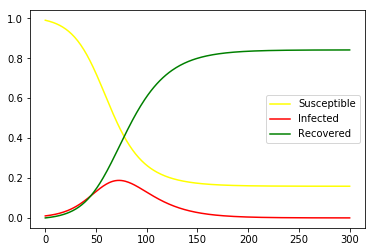

Cumulative number of infected people: 84.1%
Duration before the peak: 73


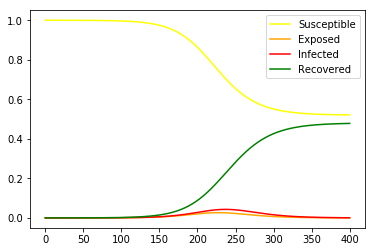

Cumulative number of infected people: 0.47809741537306305
Duration before the peak: 237


In [33]:
run corona_sir_seir.ipynb

In [111]:
def region(province, state, province_list):
    if len(province_list) == 0:
        return province == state or str(province) == 'nan' 
    else:
        return province in province_list

def clean_date(datestring):
    datestring = datestring.split('/')
    return date(2020, int(datestring[0]), int(datestring[1]))

def extract_data(country, province_list):
    data_country = data_csv[data_csv['Country_Region'].str.contains(country)]
    data_country = data_country[
        data_country.apply(lambda row: region(row['Province_State'], country, province_list), axis=1)
        ]
    data_country = data_country.reset_index()
    return data_country

In [80]:
with open('covid_19_aggregation.csv') as csv:
    data_csv = pd.read_csv(csv)

data_csv = data_csv[data_csv['ObservationDate'].notna()]
data_csv['ObservationDate'] = data_csv.apply(lambda row: clean_date(row['ObservationDate']), axis=1)
data_csv['Confirmed'] = data_csv.apply(lambda row: int(row['Confirmed']), axis=1)
data_csv['Active'] = data_csv.apply(
    lambda row: int(row['Confirmed']) - int(row['Deaths']) - int(row['Recovered'])
    , axis=1)


In this second approach, we consider three types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected
- the __exposed__ people: they carry the virus but they don't have any symptoms YET
- the __infected__ people: they carry the virus and can infect the susceptible people, but they know they are sick as they are enough advanced to have symptoms
- the __recovered__ people: they've already been infected and then they recovered or died. Either case, they can't get infected anymore.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
S'(t) & = & -p_eS(t)E(t) - p_iS(t)I(t) \\
E'(t) & = & p_eS(t)E(t) + p_iS(t)I(t) - E(t)/d_e \\
I'(t) & = & E(t)/d_e - I(t)/d_i \\
R'(t) & = & I(t)/d_i
\end{array}
\right.
$$

Where:

- $p_e$ is the __exposition rate__: depends on the number of contact between exposed and susceptible people, and the probability for a contact to be contagious.
- $p_i$ is the __infection rate__: depends on the number of contact between infected and susceptible people, and the probability for a contact to be contagious.
- $d_e$ is the __exposition duration__: the number of days people stay contagious without any symptom.
- $d_i$ is the __infection duration__: the number of days people stay contagious with symptoms.

In [150]:
# SEIR simulation
def SEIR(E0, I0, pe, pi, de, di, T):
    S, E, I, R = 1-E0-I0, E0, I0, 0
    S_list, E_list, I_list, R_list = [S], [E], [I], [R]
    for i in range(T):
        S, E, I, R = S - pe*S*E - pi*S*I, E + pe*S*E + pi*S*I - E/de, I + E/de - I/di, R + I/di
        S_list.append(S)
        E_list.append(E)
        I_list.append(I)
        R_list.append(R)
    return S_list, E_list, I_list, R_list

In [82]:
# Cost function computation 
def J(x, I_ref, regularization_methods=None, T=200):
    
    pe, pi, exposition_ratio = x[0], x[1], x[2]
    
    I0, E0 = I_ref[0], exposition_ratio*I_ref[0]
    if 'tikhonov' in regularization_methods or 'max' in regularization_methods:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 1/0.136, 1/0.0693147, T)
    else:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 6, 10, len(I_ref)-1)
    # I_diff = [sum(elts) for elts in zip(np.array(I_ref), -np.array(I_list))]
    I_list = np.array(I_list) 
    err = np.linalg.norm(I_ref-I_list[:len(I_ref)])/np.linalg.norm(I_ref)
    
    reg = 0
    if 'pe' in regularization_methods:
        reg += regularization_methods['pe']*pe
    if 'pi' in regularization_methods:
        reg += regularization_methods['pi']*pi
    if 'max' in regularization_methods:
        reg += regularization_methods['max']*np.max(I_list)
    if 'tikhonov' in regularization_methods:
        reg += regularization_methods['tikhonov']*np.linalg.norm(I_list)
    
    return err + reg

In [83]:
def random_sample_minimize(J, bounds, extra_parameters, n_grid=1000, n_iter=25, local_method='SLSQP'):

    t0 = time()

    pe_bounds, pi_bounds, exposition_ratio_bounds = bounds[0], bounds[1], bounds[2]

    pe_choice = np.random.choice(np.linspace(*pe_bounds, n_grid), n_iter)
    pi_choice = np.random.choice(np.linspace(*pi_bounds, n_grid), n_iter)
    exposition_ratio_choice = np.random.choice(np.linspace(*exposition_ratio_bounds, n_grid), n_iter)

    best_results = {'fun': float('inf')}
    for i in range(n_iter):

        pe, pi, exposition_ratio = pe_choice[i], pi_choice[i], exposition_ratio_choice[i]
        x0 = np.array([pe, pi, exposition_ratio])

        new_results = minimize(
            J, 
            x0, 
            extra_parameters, 
            method=local_method,
            bounds=[pe_bounds, pi_bounds, exposition_ratio_bounds]
        )

        if new_results['success'] and new_results['fun'] < best_results['fun']:
            
            best_results = new_results
    
    best_results['runtime'] = time()-t0
    
    return best_results

In [144]:
def analyze_data(I_ref, confinement_date):
    # Extrapolation window
    T = 200

    # Bounds for parameters we need to fit
    pe_bounds = (1E-10, 10)
    pi_bounds = (1E-10, 10)
    exposition_ratio_bounds = (1, 5)

    bounds = [pe_bounds, pi_bounds, exposition_ratio_bounds]

    n_grid = 1000
    n_iter = 50

    # Regularization methods
    regularization_methods = {
            'pe': 0,
            'pi': 0,
            'max': 0,
            'tikhonov': 0
        }

    extra_parameters = (I_ref, regularization_methods, T)

    best_results = random_sample_minimize(J, bounds, extra_parameters, n_grid, n_iter, local_method='SLSQP')

   
    best_pe, best_pi, best_exposition_ratio = best_results['x'][0], best_results['x'][1], best_results['x'][2]
    print('best results', best_pe, best_pi, best_exposition_ratio)
    print('total', best_results)

    # Fitted model
    S_list, E_list, I_list, R_list = SEIR(best_exposition_ratio*I_ref[0], I_ref[0], best_pe, best_pi, 6, 10, T)

    # Plot results
    plot_results(I_ref, S_list, E_list, I_list, R_list)

    print("Cumulative number of infected people: {}%".format(round(100*R_list[-1], 1)))
    try:
        peak_value = peak(I_list)
        date_peak = confinement_date + timedelta(peak_value)
        print("Duration before the peak: {}".format(peak_value))
        print("Date of the peak: {}".format(date_peak.strftime("%d/%m/%Y")))
    except: 
        print('No peak in the range of {} days after confinement'.format(T))
    print('=====================================================================')

In [159]:
country_pop = {
    'Korea': 51.64e6,
    'Italy': 60.36e6,
    'France': 69.99e6,
    'Germany': 83.02e6,
    'United Kingdom': 66.65e6,
    'China_Hubei': 58.5e6,
}

confinement_date = {
    
    'Korea': date(2020, 2, 10),
    'Italy': date(2020, 3, 9),
    'France': date(2020, 3, 17),
    'Germany': date(2020, 3, 22),
    'United Kingdom': date(2020, 3, 23),
    'China_Hubei': date(2020, 1, 23),
}

delay_days = 15 #number of days before we can see the impact of the confinement

In [160]:
def analyze_country(country, province_list=[]):
    
    data_country = extract_data(country, province_list)
    country_province = "_".join([country] + province_list)
    data_post_conf = data_country[
        data_country.apply(lambda row: 
                           (row['ObservationDate'] - confinement_date[country_province]).days > delay_days
        , axis=1) 
    ]

    delta = data_post_conf.iloc[-1]['ObservationDate'] - data_post_conf.iloc[0]['ObservationDate']
    if delta.days + 1 != len(np.array(data_post_conf[['ObservationDate']].T)[0]):
        print("ERROR, check if all dates are in the dataset", 
              delta.days + 1, 
              len(np.array(data_post_conf[['ObservationDate']].T)[0])
             )
        return 

    I = data_post_conf[['Active']].T
    I_ravel = [nb / country_pop[country_province] for nb in np.array(I)[0]]
    print(I_ravel)
    analyze_data(I_ravel, confinement_date[country_province])

[2.376065065840434e-05, 3.3520526723470176e-05, 4.457784663051898e-05, 6.016653756777692e-05, 7.143687064291247e-05, 8.282339271882262e-05, 9.930286599535245e-05, 0.00010737800154918668, 0.00011642137877614252, 0.00012424477149496513, 0.00013288148721920991, 0.00013838109992254068, 0.00014149883810999226, 0.0001396591789310612, 0.0001434353214562355, 0.0001446553059643687, 0.00014335786212238576, 0.0001453137103020914, 0.00014672734314484897, 0.00013601859024012393, 0.00013230054221533694, 0.00013146785437645236, 0.00013427575522850503, 0.00013590240123934934, 0.00013859411309062743, 0.0001139426800929512, 0.00011006971340046475, 0.00010476374903175833, 0.00010226568551510457, 9.616576297443841e-05, 9.033694810224633e-05, 8.758714175058095e-05, 8.516653756777692e-05, 8.278466305189776e-05, 8.164213787761425e-05, 8.046088303640589e-05, 7.705267234701782e-05, 7.488381099922541e-05, 7.075910147172735e-05, 6.953911696359411e-05, 6.777691711851278e-05, 6.671185127807901e-05, 6.5995352439969

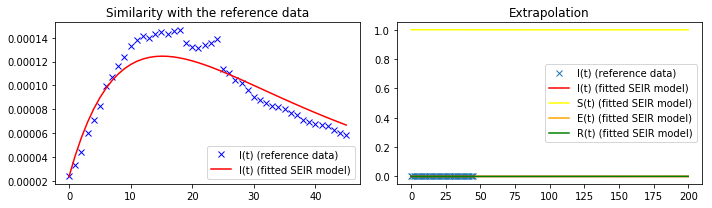

Cumulative number of infected people: 0.1%
Duration before the peak: 15
Date of the peak: 25/02/2020


In [148]:
if __name__ == '__main__':
    country = 'Korea'
    province_list = []
    analyze_country(country, province_list)

In this second approach, we consider 7 types of people:

- the __susceptible__ people: they are not immune thus they are likely to be infected

For both asymptomatics and symptomatics :
- the __exposed__ people: they have been infected but they aren't infectious yet
- the __infected__ people: they carry the virus and can infect the susceptible people
- the __recovered__ people: they've already been infected and then they recovered or died. Either way, they can't get infected anymore.

_letter d_ for disease (symptomatics).
_letter a_ for asymptomatics.

The ODE that we need to solve are as follow:

$$
\left\{
\begin{array}{r c l}
s'(t) & = & -({\lambda}_ai_a(t) + {\lambda}_di_d(t))s(t) \\
e_d'(t) & = & (p_d)({\lambda}_ai_a(t) + {\lambda}_di_d(t))s(t) - {\alpha}_de_d(t) \\
i_d'(t) & = & {\alpha}_de_d(t) - {\gamma}_di_d(t) \\
r_d'(t) & = & {\gamma}_di_d(t) \\
e_a'(t) & = & (1-p_d)({\lambda}_ai_a(t) + {\lambda}_di_d(t))s(t) - {\alpha}_ae_a(t) \\
i_a'(t) & = & {\alpha}_ae_a(t) - {\gamma}_ai_a(t) \\
r_a'(t) & = & {\gamma}_ai_a(t) \\
\end{array}
\right.
$$


Considering that :

- $p_d$ is the __probability for someone infected to become symptomatic__.
- ${\lambda}_a$ and ${\lambda}_d$ are the __infectious contact rates__ for respectively asymptomatic and symptomatic people. "Having symptomatic cases in mind, the contact rate ${\lambda}_d$ should reflect both the more likely situation that symptomatic cases have a higher viral load as compared to asymptomatic cases (thus leading to higher transmission probability upon contact), and the fact that symptomatic cases may reduce their number of social contacts and thus meet fewer individuals. Since the infectious contact rate reflect both components, it need not necessarily be that ${\lambda}_d$ > ${\lambda}_a$.." https://www.sciencedirect.com/science/article/pii/S0025556418300580
- ${\alpha}_a$ and ${\alpha}_d$ are the __infection rates__ respectively for asymptomatic and symptomatic people. These rates can be calculated from the average duration during which the patient is infected but can't transmit the infection
- ${\gamma}_a$ and ${\gamma}_d$ are the __recovery rates__ respectively for asymptomatic and symptomatic people. These rates can be calculated from the average duration during which the patient is infectious and can transmit the infection. 



We can consider some hypothesis :

- First, we can simplify the model by not separating exposed from infected people when they are asymptomatic : A ~ (SIR) 

$$
\left\{
\begin{array}{r c l}
s'(t) & = & s(t) -({\lambda}_ai_a(t) + {\lambda}_di_d(t))s(t) \\
e_d'(t) & = & p_d({\lambda}_ai_a(t) + {\lambda}_di_d(t))s(t) - {\alpha}_de_d(t) \\
i_d'(t) & = & {\alpha}_de_d(t) - {\gamma}_di_d(t) \\
r_d'(t) & = & {\gamma}_di_d(t) \\
i_a'(t) & = & (1-p_d)({\lambda}_ai_a(t) + {\lambda}_di_d(t))s(t) - {\gamma}_ai_a(t) \\
r_a'(t) & = & {\gamma}_ai_a(t) \\
\end{array}
\right.
$$

- Then, to determine the __infection rates__ and __recovery rates__, we can approximate that both the _incubation period_ and the _infection duration_ are represented by Poisson Law of parameters respectively ${\alpha}$ and ${\gamma}$. Of which we know the repartition function : 
$$F(x) = 1 - exp(-{\alpha}t)$$ From there, as we know that the average __incubation period__ is 5.1 days and the __infectious period__ is 10 days for __symptomatic people__. We can estimate ${\alpha}_d$ and ${\gamma}_d$ : __THOSE ARE BIG APPROXIMATIONS__
$$ {\alpha}_d = - ln(0.5) / 5.1 = 0.136$$ 
$$ {\gamma}_d = - ln(0.5) / 10 = 0.0693$$ 


- We need to make hypothesis on the initial conditions $s(0)$, $e_d(0)$, $i_d(0)$ and $i_a(0)$


Are left to estimate : 
${\lambda}_a$, ${\lambda}_d$, ${\gamma}_a$ and $p_d$

In [152]:
initial_exposed_factor = 2.1
initial_asymptomatic_factor = 1/(1-0.85) # 85% of asymptomatics

a_d_def = 0.136
g_d_def = 0.0693

In [181]:
# SEIR simulation
def SEIA(I_d0, l_a, l_d, a_d, g_d, g_a, p_d, T):
    E_d0 = initial_exposed_factor*I0
    I_a0 = initial_asymptomatic_factor*I0
    
    S, E_d, I_d , I_a = 1 - E_d0 - I0 - I_a0, E_d0, I_d0, I_a0
    
    S_list, E_d_list, I_d_list, I_a_list = [S], [E_d], [I_d], [I_a]
    for i in range(T):
        S, E_d, I_d, I_a = \
            S - S*(l_a*I_a + l_d*I_d),E_d + p_d*S*(l_a*I_a + l_d*I_d) - a_d*E_d, I_d + a_d*E_d - g_d*I_d, I_a + (1-p_d)*S*(l_a*I_a + l_d*I_d) - g_a*I_a
        S_list.append(S)
        E_d_list.append(E_d)
        I_d_list.append(I_d)
        I_a_list.append(I_a)
    return S_list, E_d_list, I_d_list, I_a_list


In [192]:
def J(x, I_ref, regularization_methods=None, T=200):
    
    l_a, l_d, a_d, g_d, g_a, p_d = x[0], x[1], x[2], x[3], x[4], x[5]
    
    I0 = I_ref[0]
    
    if 'tikhonov' in regularization_methods or 'max' in regularization_methods:
        S_list, E_list, I_list, R_list = SEIA(I0, l_a, l_d, a_d, g_d, g_a, p_d, T)
    else:
        S_list, E_list, I_list, R_list = SEIA(I0, l_a, l_d, a_d, g_d, g_a, p_d, len(I_ref)-1)
    # I_diff = [sum(elts) for elts in zip(np.array(I_ref), -np.array(I_list))]
    I_list = np.array(I_list) 
    err = np.linalg.norm(I_ref-I_list[:len(I_ref)])/np.linalg.norm(I_ref)
    
    reg = 0
    if 'pe' in regularization_methods:
        reg += regularization_methods['pe']*pe
    if 'pi' in regularization_methods:
        reg += regularization_methods['pi']*pi
    if 'max' in regularization_methods:
        reg += regularization_methods['max']*np.max(I_list)
    if 'tikhonov' in regularization_methods:
        reg += regularization_methods['tikhonov']*np.linalg.norm(I_list)
    
    return err + reg

In [193]:
def random_sample_minimize(J, list_bounds, extra_parameters, n_grid=1000, n_iter=25, local_method='SLSQP'):

    t0 = time()

    choices = [np.random.choice(np.linspace(*bounds), n_iter) for bounds in list_bounds]

    best_results = {'fun': float('inf')}
    for i in range(n_iter):
        choice_i = [choice[i] for choice in choices]
        x0 = np.array(choice_i)

        new_results = minimize(
            J, 
            x0, 
            extra_parameters, 
            method=local_method,
            bounds=list_bounds
        )

        if new_results['success'] and new_results['fun'] < best_results['fun']:
            
            best_results = new_results
    
    best_results['runtime'] = time()-t0
    
    return best_results

In [224]:
def analyze_data_SEIA(I_ref, confinement_date):
    # Extrapolation window
    T = 200

    # Bounds for parameters we need to fit
    l_a_bounds = (1E-100, 10)
    l_d_bounds = (1E-100, 10)
    a_d = (1E-100, 1)
    g_d = (1E-100, 1)
    g_a = (1E-100, 1)
    p_d = (0, 0.25)

    bounds = [l_a_bounds, l_d_bounds, a_d, g_d, g_a, p_d]

    n_grid = 1000
    n_iter = 50

    # Regularization methods
    regularization_methods = {
            'pe': 0,
            'pi': 0,
            'max': 0,
            'tikhonov': 0
        }

    extra_parameters = (I_ref, regularization_methods, T)

    best_results = random_sample_minimize(J, bounds, extra_parameters, n_grid, n_iter, local_method='SLSQP')

   
    l_a, l_d, a_d, g_d, g_a, p_d = \
        best_results['x'][0], best_results['x'][1], best_results['x'][2], best_results['x'][3], best_results['x'][4], best_results['x'][5]
    
    print('=====================')
    print("Average number person contaminated per day per asymptomatics : {}".format(l_a))
    print("Average number person contaminated per day per symptomatics : {}".format(l_d))
    print('=====================')    
    print("Average duration of incubation period for symptomatics : {}".format(-np.log(1 - 0.5)/a_d))
    print('=====================')
    print("Average duration of infectious period for symptomatics : {}".format(-np.log(1 - 0.5)/g_d))
    print("Average duration of infectious period for asymptomatics : {}".format(-np.log(1 - 0.5)/g_a))
    print('=====================')
    print("Probability for someone to be symptomatic when infected: {}".format(p_d))
    print('=====================')
    print('total', best_results)

    # Fitted model
    S_list, E_list, I_list, R_list = SEIA(I_ref[0], l_a, l_d, a_d, g_d, g_a, p_d, T)

    # Plot results
    plot_results(I_ref, S_list, E_list, I_list, R_list)

    print("Cumulative number of infected people: {}%".format(round(100*R_list[-1], 1)))
    try:
        peak_value = peak(I_list)
        date_peak = confinement_date + timedelta(peak_value)
        print("Duration before the peak: {}".format(peak_value))
        print("Date of the peak: {}".format(date_peak.strftime("%d/%m/%Y")))
    except: 
        print('No peak in the range of {} days after confinement'.format(T))
    print('=====================================================================')

In [222]:
def analyze_country_SEIA(country, province_list=[]):
    
    data_country = extract_data(country, province_list)
    country_province = "_".join([country] + province_list)
    data_post_conf = data_country[
        data_country.apply(lambda row: 
                           (row['ObservationDate'] - confinement_date[country_province]).days > delay_days
        , axis=1) 
    ]

    delta = data_post_conf.iloc[-1]['ObservationDate'] - data_post_conf.iloc[0]['ObservationDate']
    if delta.days + 1 != len(np.array(data_post_conf[['ObservationDate']].T)[0]):
        print("ERROR, check if all dates are in the dataset", 
              delta.days + 1, 
              len(np.array(data_post_conf[['ObservationDate']].T)[0])
             )
        return 

    I = data_post_conf[['Active']].T
    I_ravel = [nb / country_pop[country_province] for nb in np.array(I)[0]]
    print("Number of days analyzed : {}".format(len(I_ravel)))
    analyze_data_SEIA(I_ravel, confinement_date[country_province])

Number of days analyzed : 64
Average number person contaminated per day per asymptomatics : 3.5630737361535663
Average number person contaminated per day per symptomatics : 10.0
Average duration of incubation period for symptomatics : 2.0539905060880748
Average duration of infectious period for symptomatics : 9.24035667908316
Average duration of infectious period for asymptomatics : 1.454559340079576
Probability for someone to be symptomatic when infected: 0.0012540528753025892
total      fun: 0.09935859256865749
     jac: array([ 3.20030376e-05, -1.39559619e-03, -1.64154917e-05, -2.73480359e-03,
       -2.56747007e-05,  1.07841540e-01])
 message: 'Optimization terminated successfully.'
    nfev: 830
     nit: 98
    njev: 98
 runtime: 48.13920593261719
  status: 0
 success: True
       x: array([3.56307374e+00, 1.00000000e+01, 3.37463673e-01, 7.50130330e-02,
       4.76534137e-01, 1.25405288e-03])


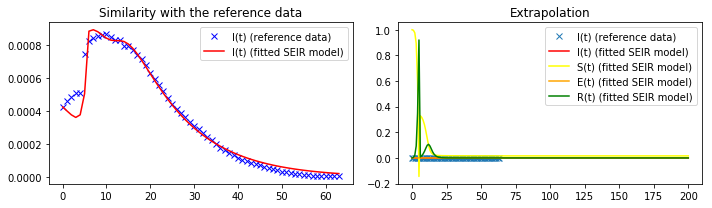

Cumulative number of infected people: 0.0%
Duration before the peak: 0
Date of the peak: 23/01/2020


In [225]:
if __name__ == '__main__':
    country = 'China'
    province_list = ['Hubei']
    analyze_country_SEIA(country, province_list)